# 1. Import Dependencies

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import matplotlib.patheffects as PathEffects
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from neural_network_classes import LSTM, DARNN, HARHN

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
timesteps = 10 # lookback window
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

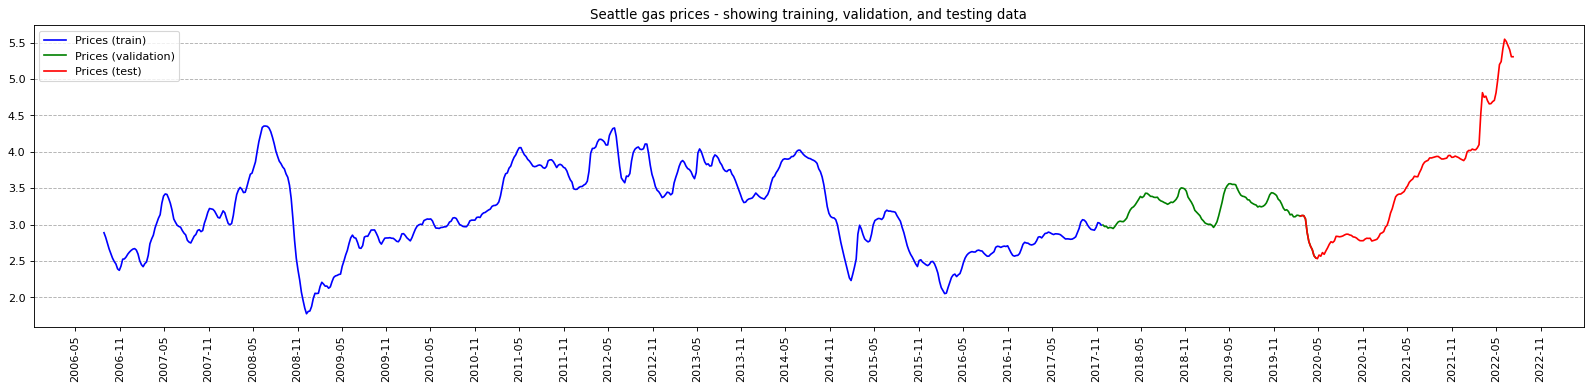

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 6. Modeling

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, target_scaler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                y_pred, alpha, beta = model(batch_x, batch_y_h)
            elif model_name == 'harhn':
                y_pred = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, batch_y_h, h, c)
                elif model_name == 'darnn':
                    output, alpha, beta = model(batch_x, batch_y_h)
                elif model_name == 'harhn':
                    output = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
#             preds = preds*(target_train_max - target_train_min) + target_train_min
#             true = true*(target_train_max - target_train_min) + target_train_min
            preds = target_scaler.inverse_transform(preds)
            true = target_scaler.inverse_transform(true)
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(12, 6))
            plt.plot(preds, label='predicted')
            plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
            plt.legend(loc="upper left")
            plt.title(f'Validation Results for Epoch {i}')
            plt.show()
    return

In [78]:
def nn_eval(model, model_name, data_test_loader, target_scaler):
    
    with torch.no_grad():
        mse_val = 0
        loss = nn.MSELoss()
        preds = []
        true = []
        alphas = []
        betas = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                output, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                output, alpha, beta = model(batch_x, batch_y_h)
                alphas.append(alpha.detach().cpu().numpy())
                betas.append(beta.detach().cpu().numpy())
            elif model_name == 'harhn':
                output = model(batch_x, batch_y_h)
                
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    if model_name == 'darnn':
        alphas = np.concatenate(alphas)
        betas = np.concatenate(betas)
    
    # De-normalize
    preds = target_scaler.inverse_transform(preds)
    true = target_scaler.inverse_transform(true)
    
    # Collect results
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pcc, _ = PCC(true, preds)  
    err = true - preds
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(preds, label='preds')
    plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
    plt.legend(loc="upper left")
    plt.title(f'Test Results for {model_name.upper()} Model', fontsize=15)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Seattle Gas Price', fontsize=12)
    plt.show()
    
    # Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(ax=ax, x=true, y=preds)
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predictions', fontsize=12)
    ax.set_title(f'Test Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc:.3f}', fontsize=15)
    ax.set_aspect('equal', 'box')
    
    # Error Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ax=ax, data=err, kde=True)
    ax.set_xlabel('Prediction Errors (U.S. $)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Model Testing Prediction Errors \n MSE = {mse:.3f} \n MAE = {mae:.3f}', fontsize=15)
        
    if model_name == 'darnn':
        alphas = alphas.mean(axis=0)
        betas = betas.mean(axis=0).squeeze()[::-1]

        attn = np.zeros([len(alphas), len(betas)])
        for i in range(len(alphas)):
            for j in range(len(betas)):
                attn[i,j] = (alphas[i] + betas[j]) / 2
                
        max_attn = np.amax(attn)
        min_attn = np.amin(attn)
        min_range = min_attn + (0.25 * (max_attn - min_attn))
        max_range = max_attn - (0.25 * (max_attn - min_attn))

        # Attention Weights Heatmap
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(attn, cmap='rainbow')
        cols = features_targets.columns[0:-1].tolist()
        ax.set_xticks(np.arange(len(betas)))
        ax.set_yticks(np.arange(len(alphas)))
        ax.set_xticklabels(["t-"+str(i) for i in np.arange(len(betas), 0, -1)])
        ax.set_yticklabels(cols)
        for i in range(len(cols)):
            for j in range(len(betas)):
                val = round(attn[i, j], 3)
                if val < max_range and val > min_range:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="w")
        ax.set_title(f"DA-RNN Attention Weights:\nImportance of Features and Timesteps")
        cbar = fig.colorbar(im, ax=ax, label='More Important \u2192')
        cbar.set_label(label='\n More Important \u2192',size='12')
        plt.show()
        
        # Feature Importance Bar Plot
        plt.figure(figsize=(8, 8))
        plt.title("Feature Importance\n(All Timesteps along Lookback Window)")
        plt.bar(range(len(cols)), alphas)
        plt.xticks(range(len(cols)), cols, rotation=90)
        plt.ylabel('Attention Weight')
    
    return mse, mae, r2, pcc, preds, true, alphas, betas

In [39]:
def nn_forecast(model, model_name, data, timesteps, n_timeseries, true, preds, x_scaler, y_his_scaler, target_scaler, plot_range=10):

    data = data.to_numpy()
    
    data_x_unseen = data[-timesteps:,:-1]
    y_hist_unseen = data[-timesteps:,-1]
    y_hist_unseen = np.expand_dims(y_hist_unseen, axis=1)
    
    data_x_unseen = x_scaler.transform(data_x_unseen)
    y_hist_unseen = y_his_scaler.transform(y_hist_unseen)
    
    x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0)
    y_hist = torch.tensor(y_hist_unseen).float().to(device).unsqueeze(0)

    model.eval()
    if model_name == 'lstm':
        h0, c0 = model.init_hidden_internal(x.shape[0])
        prediction, h, c = model(x, y_hist, h0, c0)
    elif model_name == 'darnn':
        prediction, alpha, beta = model(x, y_hist)
    elif model_name == 'harhn':
        prediction = model(x, y_hist)
        
    prediction = prediction.cpu().detach().numpy()

    # prepare plots

    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = true[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = preds[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = target_scaler.inverse_transform(prediction)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    next_week = plot_date_test[-1] + dt.timedelta(days=7)
    plot_date_test.append(next_week)

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color='black')
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10)
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color='red')
    plt.title("Predicted Seattle gas price of the next week")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print(f'{model_name.upper()} Predicted Seattle Gas Price of the next week: ${to_plot_data_y_test_pred[plot_range-1]:.2f}')
    
    return

## 6a. Time Series Model (Neural Prophet)

### Training

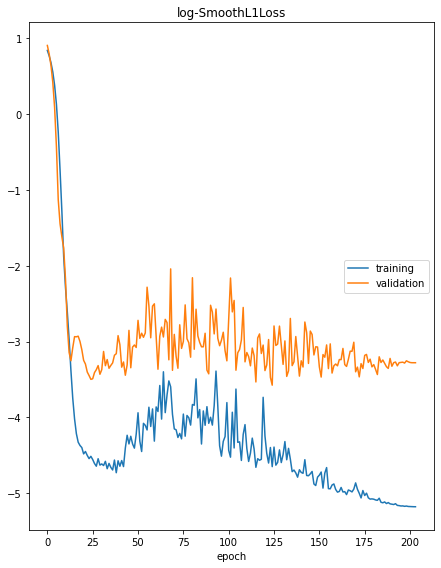

log-SmoothL1Loss
	training         	 (min:   -5.177, max:    0.840, cur:   -5.177)
	validation       	 (min:   -3.574, max:    0.906, cur:   -3.278)


In [40]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [41]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005645,0.197432,0.261752,0.0,0.037707,0.575045,0.696422


### Evaluation

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.038  0.575  0.696


   SmoothL1Loss       MAE      RMSE
0      0.037707  0.575045  0.696422


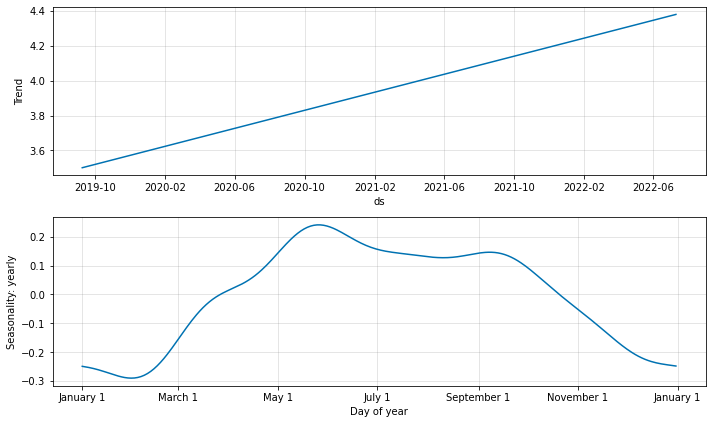

In [42]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


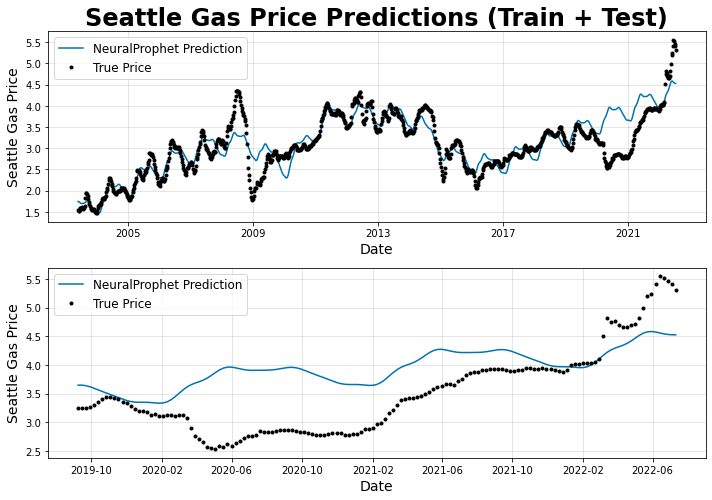

In [43]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

### Forecasting

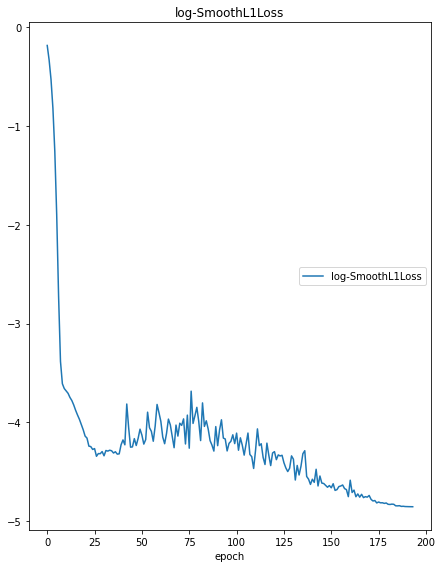

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.856, max:   -0.183, cur:   -4.856)


In [44]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


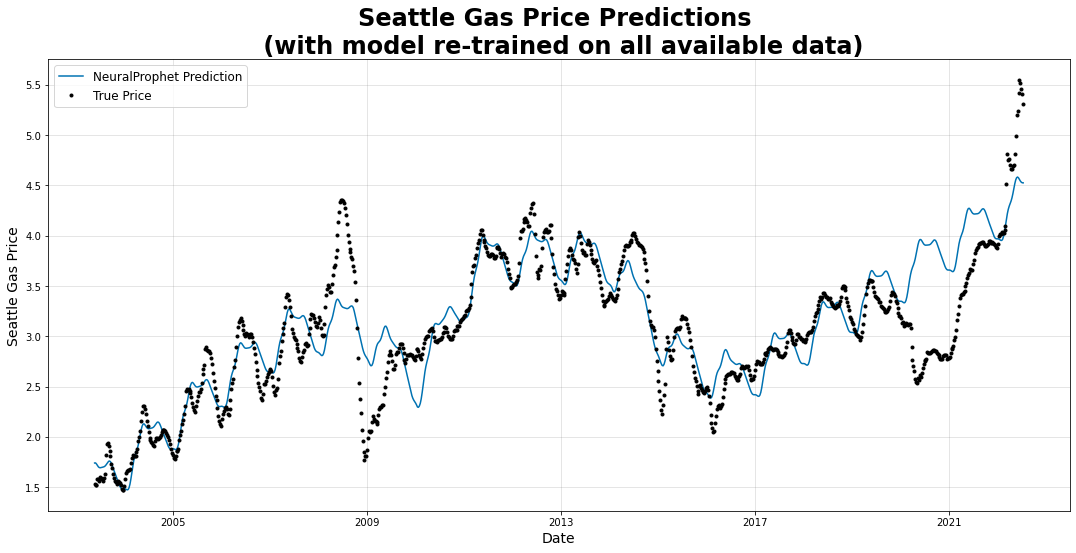

In [45]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [46]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

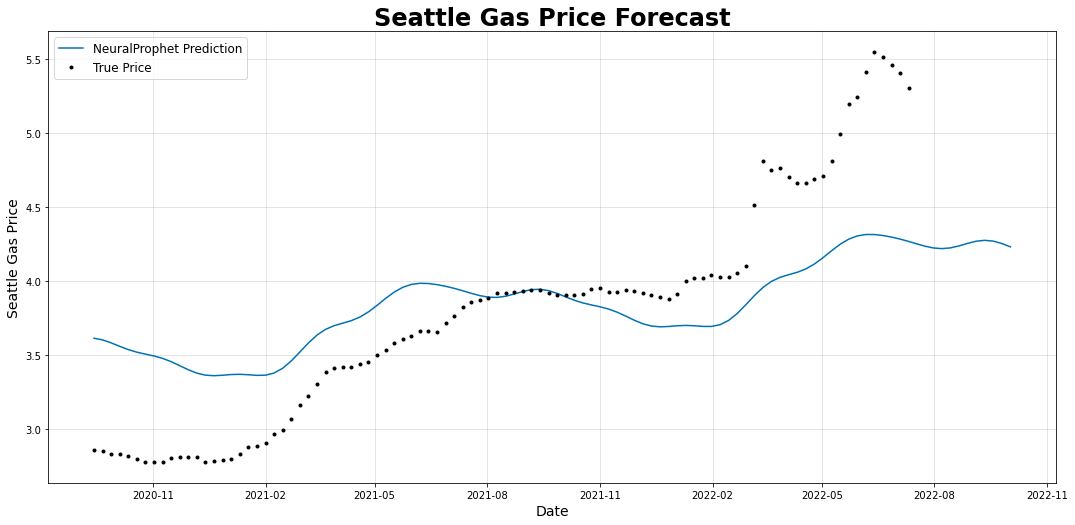

In [47]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

### Training

In [48]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=64, num_layers=2, # hidden=64, layers=2
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = torch.optim.Adam(lstm.parameters(), lr=0.01)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.041102).  Saving model ...
Iter:  0 train:  0.26771646042133723 val:  0.2027373617137565 LR:  0.01
mse:  0.27380642 mae:  0.49458873


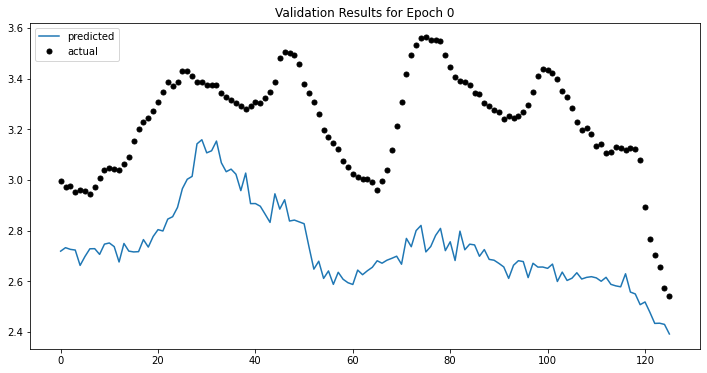

Validation loss decreased (0.041102 --> 0.007683).  Saving model ...
Iter:  1 train:  0.08800966378456596 val:  0.0876543885374324 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.07135963956233794 val:  0.1322929851765216 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.05743915048196511 val:  0.13894730438853273 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  4 train:  0.053528390940365635 val:  0.13273904286774255 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  5 train:  0.04634094640995303 val:  0.14031479538751251 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  6 train:  0.046691420380334234 val:  0.11683907520321131 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  7 train:  0.0446568376275539 val:  0.12007405285242023 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  8 train:  0.04326157711029455 val:  0.1359744769462221 LR:  0.01
Validation loss decreased (0.007683 --> 0.007652).  Saving model ...
Iter:  9 train:  0.0446443656629330

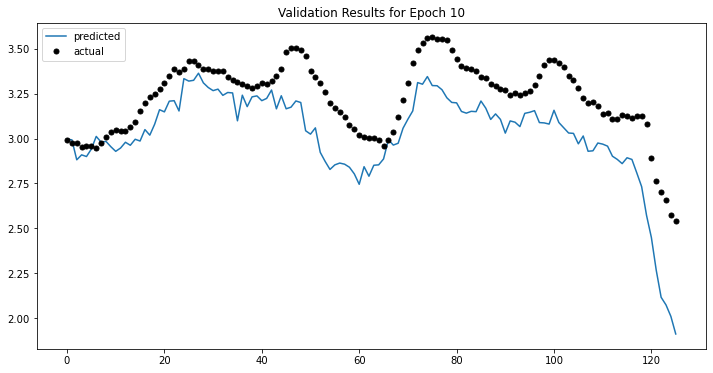

Validation loss decreased (0.007652 --> 0.007599).  Saving model ...
Iter:  11 train:  0.036417064552811275 val:  0.08717037768218383 LR:  0.01
Validation loss decreased (0.007599 --> 0.004520).  Saving model ...
Iter:  12 train:  0.03798582580075979 val:  0.06723398304852854 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  13 train:  0.039177365293456216 val:  0.10115638131679167 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  14 train:  0.03504866080060588 val:  0.10182998628851357 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  15 train:  0.0337526273791481 val:  0.10323265559891297 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  16 train:  0.03264988961486791 val:  0.10067984652850985 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  17 train:  0.04010339884544938 val:  0.1468274669183445 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  18 train:  0.04020778872976143 val:  0.09018941903038284 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  19 train:  0.03155

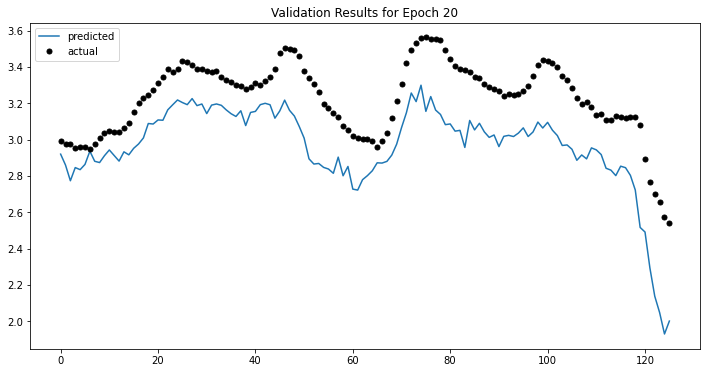

EarlyStopping counter: 9 out of 50
Iter:  21 train:  0.030354601944547248 val:  0.07777271040145872 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  22 train:  0.03079116804293937 val:  0.09022586676630316 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  23 train:  0.032758826527249804 val:  0.09077518495687215 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  24 train:  0.032666945393531883 val:  0.10550517984203886 LR:  0.01
Validation loss decreased (0.004520 --> 0.002988).  Saving model ...
Iter:  25 train:  0.03873905094259455 val:  0.054662940530994575 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  26 train:  0.033680872701906124 val:  0.059227672648228674 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  27 train:  0.029713443280461032 val:  0.08872313046040152 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  28 train:  0.0309321932767021 val:  0.08084961971400886 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  29 train:  0.02939614693403416 val:  0.0683

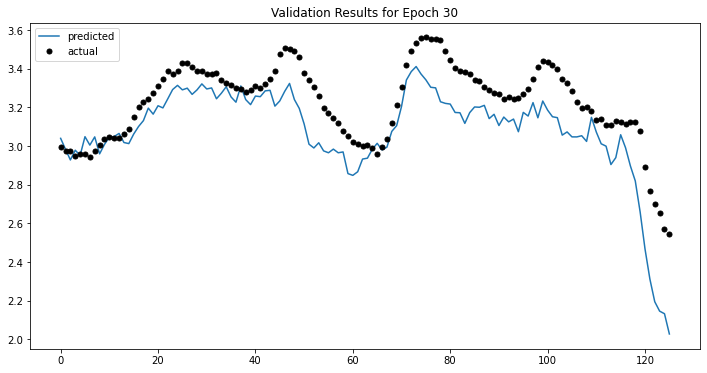

EarlyStopping counter: 6 out of 50
Iter:  31 train:  0.025200954790126403 val:  0.07688088020898699 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  32 train:  0.027413502195537075 val:  0.059694215558990404 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  33 train:  0.029665216371129448 val:  0.08727189708838501 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  34 train:  0.025909043795988445 val:  0.07119753052884538 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  35 train:  0.026065286079035438 val:  0.06952556369698194 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  36 train:  0.03226803734461748 val:  0.09055217958365389 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  37 train:  0.02951376004820599 val:  0.10010806955127886 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  38 train:  0.027527610303922187 val:  0.06669789181431739 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  39 train:  0.024726654671707475 val:  0.06089520473319735 LR:  0.01
EarlyS

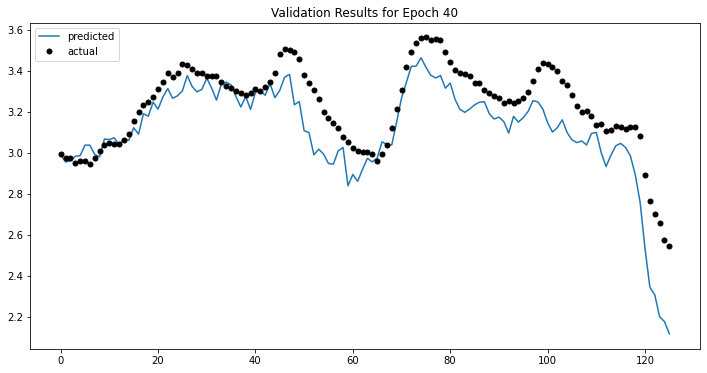

EarlyStopping counter: 16 out of 50
Iter:  41 train:  0.026192272734651197 val:  0.06484657246528848 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  42 train:  0.020663584146461324 val:  0.06733299740151479 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  43 train:  0.018667544022912687 val:  0.06819172812801125 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  44 train:  0.018150056098203058 val:  0.06575555460702456 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  45 train:  0.017946838771212528 val:  0.062960034504187 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  46 train:  0.01813530841555611 val:  0.06370808103086935 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  47 train:  0.018898604831382667 val:  0.06724766247567701 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  48 train:  0.01817329113799387 val:  0.06402736763505741 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  49 train:  0.01796654864246813 val:  0.06492793774619292 LR:  0.0

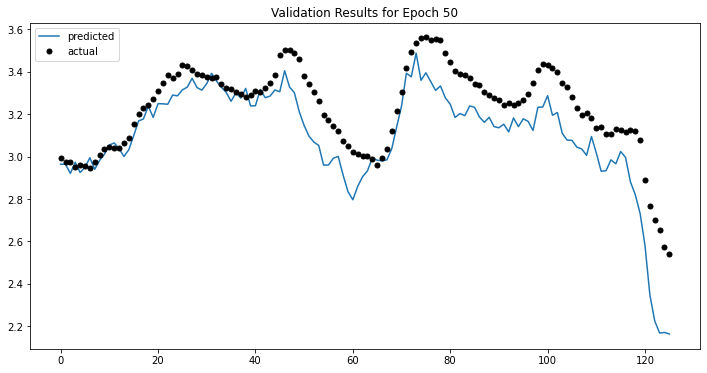

EarlyStopping counter: 26 out of 50
Iter:  51 train:  0.018256950338858522 val:  0.059010374523890595 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  52 train:  0.018329596778918524 val:  0.06304914785454131 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  53 train:  0.018653424893212676 val:  0.06596255050715971 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  54 train:  0.017641672884901254 val:  0.06307081841141585 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  55 train:  0.016971715563136324 val:  0.06801771763282921 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  56 train:  0.017369410565016934 val:  0.061982382660482414 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  57 train:  0.01803502099147608 val:  0.06372929851885767 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  58 train:  0.017537343564019453 val:  0.06026927708590035 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  59 train:  0.017191950422878504 val:  0.06331590359922243 

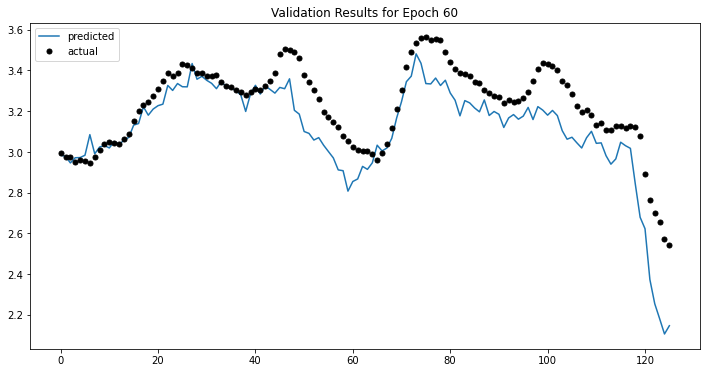

EarlyStopping counter: 36 out of 50
Iter:  61 train:  0.016280117389905903 val:  0.06148802181718021 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  62 train:  0.017452519813423797 val:  0.06127199476729449 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  63 train:  0.01641779838979066 val:  0.06265696784548776 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  64 train:  0.01723573204579399 val:  0.06093370455907839 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  65 train:  0.017151214417996875 val:  0.06020134356497639 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  66 train:  0.01800604345146664 val:  0.06137690080301179 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  67 train:  0.017271339862500266 val:  0.0636964640629791 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  68 train:  0.01673971332961926 val:  0.06022459436288931 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  69 train:  0.016623169774363646 val:  0.05990778287261228 

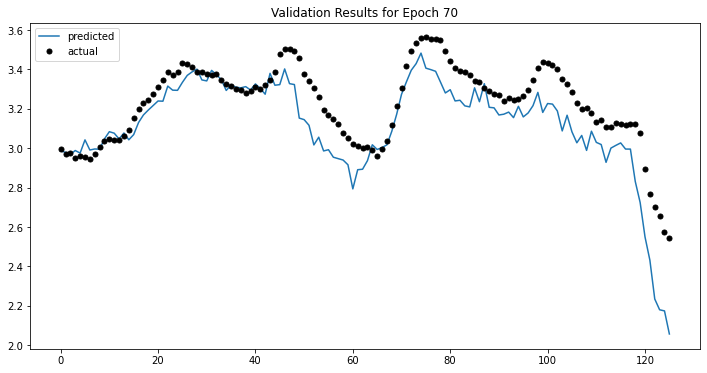

EarlyStopping counter: 46 out of 50
Iter:  71 train:  0.017262759759045773 val:  0.05966743579820031 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  72 train:  0.016846209916527105 val:  0.0572920885421446 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  73 train:  0.016198027680577622 val:  0.05889027718145836 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  74 train:  0.015998075812563354 val:  0.057446127680885195 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [49]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [50]:
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

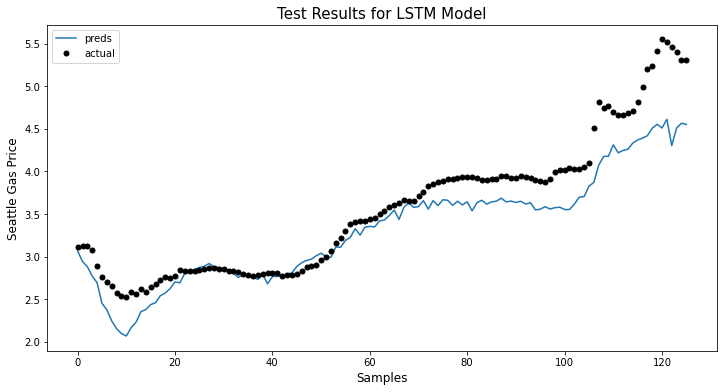

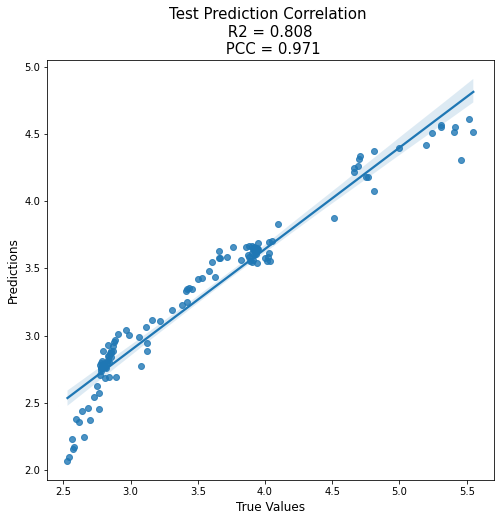

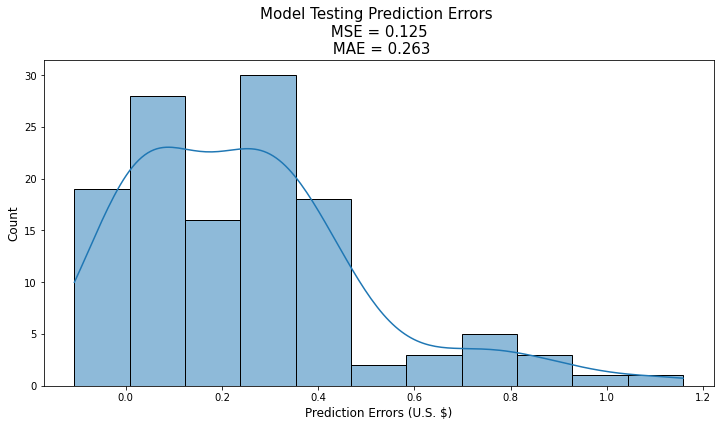

In [51]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true, _, _ = nn_eval(model=lstm, 
                                                                             model_name='lstm', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

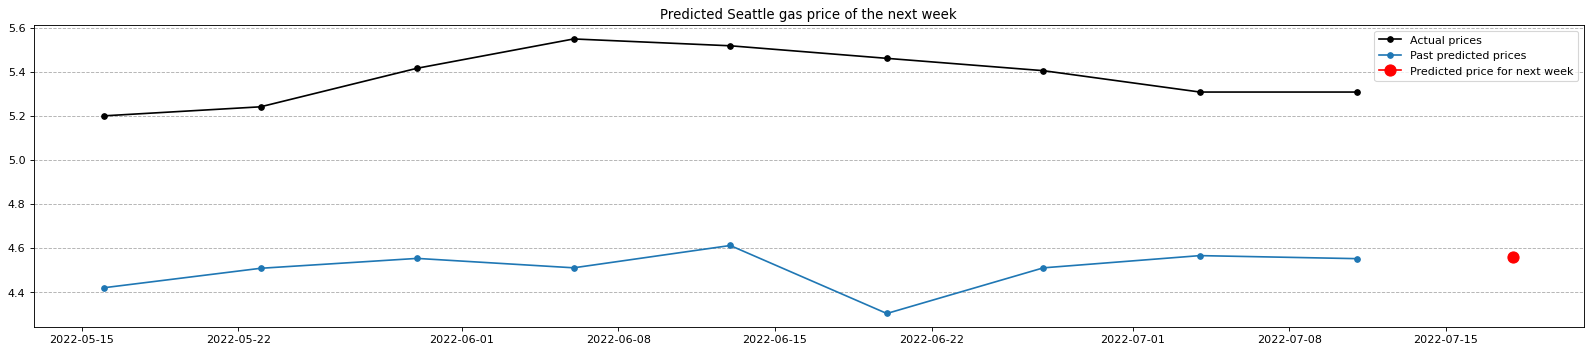

LSTM Predicted Seattle Gas Price of the next week: $4.56


In [52]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6c. Dual-Stage Attention-Based Recurrent Neural Network (DA-RNN)

### Training

In [53]:
darnn = DARNN(N=X_train.shape[2], M=64, P=16, T=X_train.shape[1], device=device).to(device) # 1) M=64, P=16
model_name = 'darnn'
darnn_opt = torch.optim.Adam(darnn.parameters(), lr=0.01)
darnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15)

Validation loss decreased (inf --> 0.005969).  Saving model ...
Iter:  0 train:  0.26654177253061123 val:  0.07726193830609616 LR:  0.01
mse:  0.039765567 mae:  0.15612352


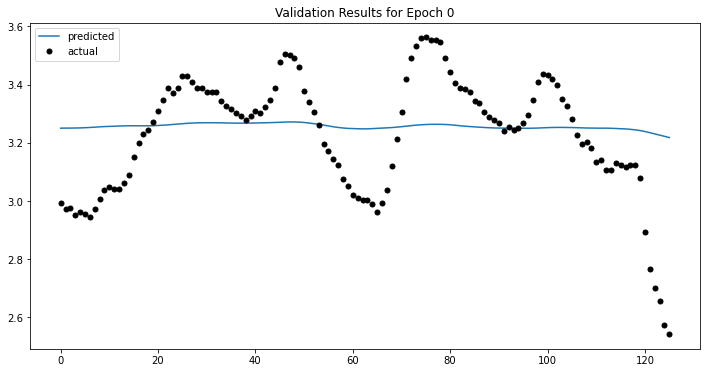

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.16277869612006218 val:  0.10077284211746561 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.0746901551774197 val:  0.14480588722410695 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  3 train:  0.06059510493176437 val:  0.14074349719520626 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  4 train:  0.05445991713579938 val:  0.12338518475905615 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  5 train:  0.04448003075233537 val:  0.09525200984395067 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  6 train:  0.04158498810729269 val:  0.09599484529228398 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  7 train:  0.03530788451657392 val:  0.09203146031698232 LR:  0.01
Validation loss decreased (0.005969 --> 0.004583).  Saving model ...
Iter:  8 train:  0.03257189789081335 val:  0.06769889991364704 LR:  0.01
Validation loss decreased (0.004583 --> 0.003830).  Saving model ...
Iter:  9 train:  0.030134544496501

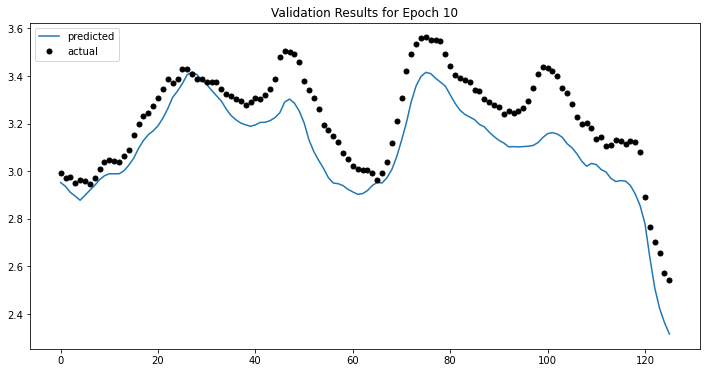

EarlyStopping counter: 1 out of 50
Iter:  11 train:  0.02586193500883669 val:  0.05819765642236533 LR:  0.01
Validation loss decreased (0.003236 --> 0.001820).  Saving model ...
Iter:  12 train:  0.027108544081627405 val:  0.04265862282478571 LR:  0.01
Validation loss decreased (0.001820 --> 0.001776).  Saving model ...
Iter:  13 train:  0.020310442171742018 val:  0.04213948237022012 LR:  0.01
Validation loss decreased (0.001776 --> 0.000740).  Saving model ...
Iter:  14 train:  0.020873760476376124 val:  0.027210956308165016 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  15 train:  0.020563487747089493 val:  0.047734791090604134 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  16 train:  0.01872646357104463 val:  0.04517566368387682 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  17 train:  0.01995075942489812 val:  0.04501481311422173 LR:  0.01
Validation loss decreased (0.000740 --> 0.000736).  Saving model ...
Iter:  18 train:  0.020443971664939286 val:  0.0271277317382

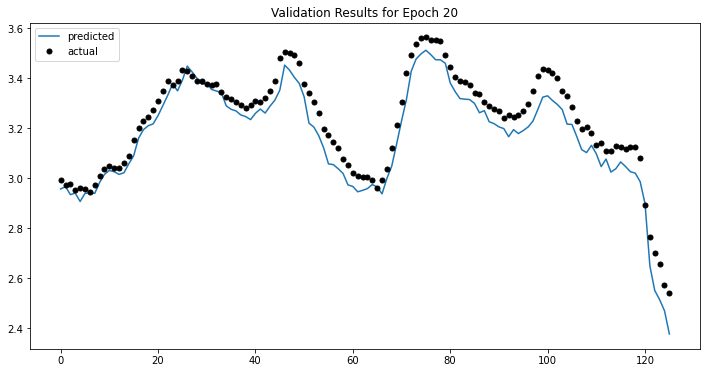

Validation loss decreased (0.000736 --> 0.000190).  Saving model ...
Iter:  21 train:  0.017068314269758543 val:  0.013775807547462082 LR:  0.01
Validation loss decreased (0.000190 --> 0.000177).  Saving model ...
Iter:  22 train:  0.01880015143103618 val:  0.013312118616540435 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  23 train:  0.016675650571114992 val:  0.03169280081338357 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  24 train:  0.019799339494737445 val:  0.01564339705589194 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  25 train:  0.015584802834002556 val:  0.02544094916830826 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  26 train:  0.014803622497007195 val:  0.014563306235199395 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  27 train:  0.01515908767268203 val:  0.023702136124430263 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  28 train:  0.01626279282628007 val:  0.01765183183354165 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  29 train:

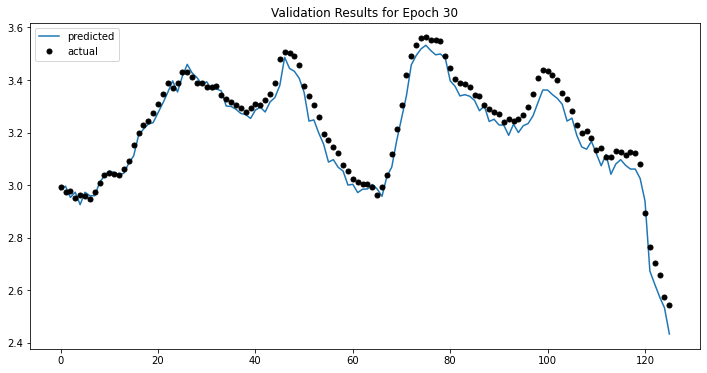

EarlyStopping counter: 9 out of 50
Iter:  31 train:  0.01462340675619852 val:  0.02851704540461124 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  32 train:  0.0173072441495233 val:  0.013557194619929202 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  33 train:  0.016059851088869218 val:  0.021906033984400667 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  34 train:  0.014433528390486533 val:  0.019208919289644025 LR:  0.01
Validation loss decreased (0.000177 --> 0.000175).  Saving model ...
Iter:  35 train:  0.016738436523749733 val:  0.013226693967781353 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  36 train:  0.01463445406111467 val:  0.017098120574074775 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  37 train:  0.01501529122616521 val:  0.022174594443446678 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  38 train:  0.015255571251081554 val:  0.015472613824464784 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  39 train:  0.014904073644393922 val:  0

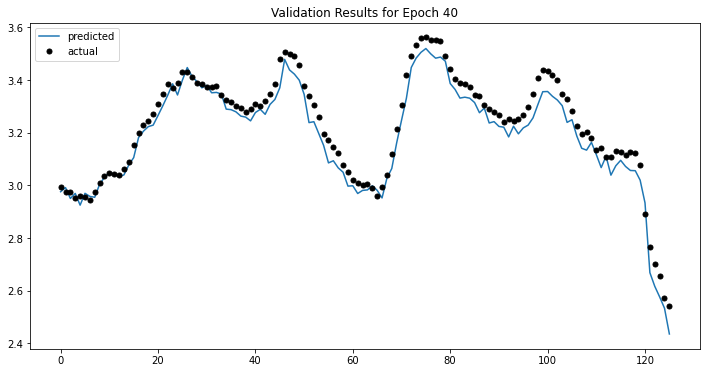

EarlyStopping counter: 6 out of 50
Iter:  41 train:  0.015332613976144816 val:  0.023545647702840053 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  42 train:  0.014931695529538188 val:  0.03763894253704143 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  43 train:  0.01621607782349676 val:  0.01937435927440015 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  44 train:  0.015153029037594632 val:  0.01755941142716816 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  45 train:  0.015061569366584968 val:  0.0223790265718094 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  46 train:  0.01633474902965614 val:  0.015552378508278238 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  47 train:  0.015896242153052534 val:  0.02285081766188031 LR:  0.01
Validation loss decreased (0.000175 --> 0.000141).  Saving model ...
Iter:  48 train:  0.014678833299191877 val:  0.011887110805844227 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  49 train:  0.015868943109084217 val:  0.0

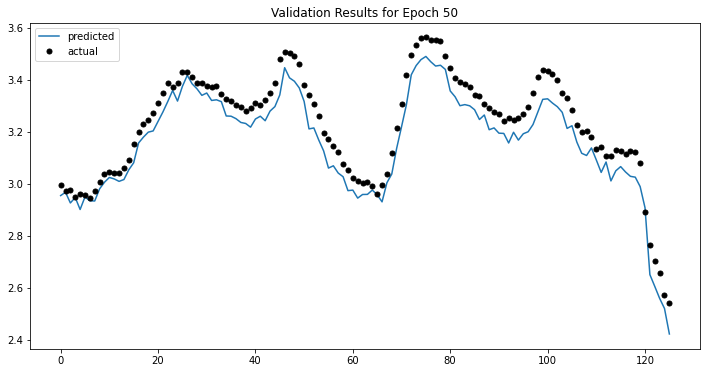

EarlyStopping counter: 3 out of 50
Iter:  51 train:  0.025981806699012143 val:  0.034697995474815814 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  52 train:  0.017075676299226884 val:  0.021646213093567145 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  53 train:  0.01545928069820626 val:  0.016929729501769016 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  54 train:  0.014670889900810776 val:  0.02181846510291781 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  55 train:  0.018332299068932294 val:  0.022166613596292274 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  56 train:  0.017287693702661196 val:  0.019921380822576225 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  57 train:  0.014200881057430758 val:  0.021670464967459006 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  58 train:  0.018438520685490494 val:  0.038260192119916894 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  59 train:  0.020918072207474537 val:  0.02779574453425578 LR:  0.01
Ea

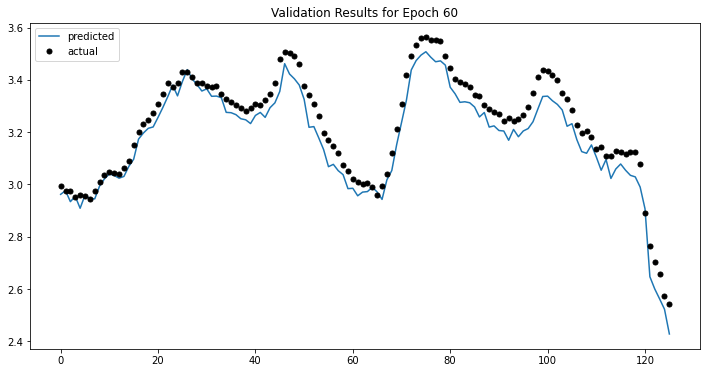

EarlyStopping counter: 13 out of 50
Iter:  61 train:  0.014954035125240862 val:  0.01753960544795688 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  62 train:  0.015441476991678952 val:  0.015099538875560096 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  63 train:  0.015666606264905365 val:  0.012000881100084598 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  64 train:  0.021330576212545253 val:  0.019675669601123904 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  65 train:  0.013080179098818203 val:  0.02584389186922677 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  66 train:  0.012898262796238581 val:  0.02065115990751201 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  67 train:  0.012781711777319705 val:  0.02297382147541192 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  68 train:  0.012909865578295562 val:  0.023248984324094852 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  69 train:  0.012958992214102375 val:  0.02475337710421591 LR

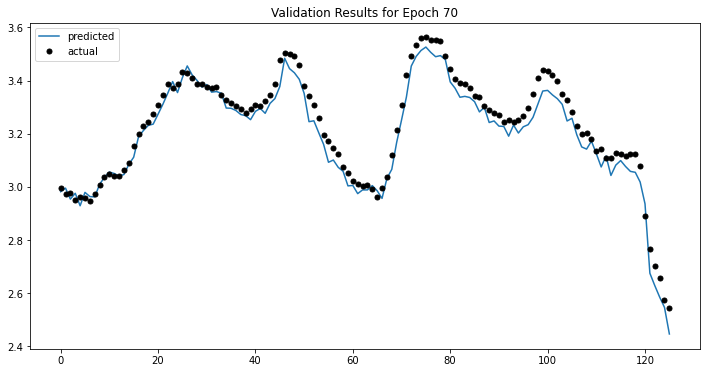

EarlyStopping counter: 23 out of 50
Iter:  71 train:  0.013133604099852538 val:  0.02081193247844921 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  72 train:  0.01299813700335657 val:  0.021848025932685883 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  73 train:  0.013341556913083238 val:  0.025205314647120603 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  74 train:  0.013127415958113233 val:  0.02125568331343233 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  75 train:  0.012689569501049443 val:  0.02264224030850593 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  76 train:  0.012925248740163263 val:  0.024393571852975946 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  77 train:  0.012906315538981139 val:  0.02008959380065821 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  78 train:  0.012927787035595429 val:  0.01974948084713537 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  79 train:  0.012716160582860864 val:  0.023145490439756142 

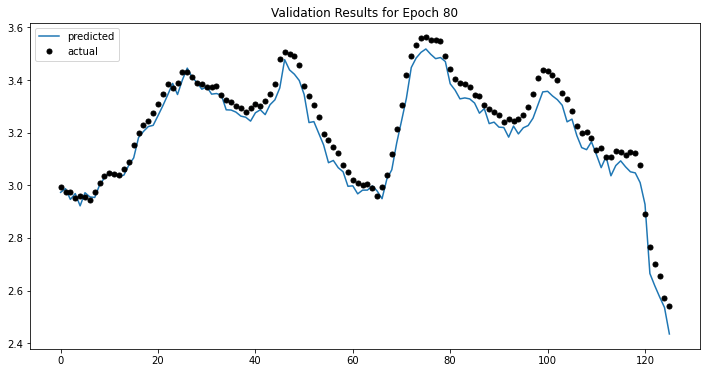

EarlyStopping counter: 33 out of 50
Iter:  81 train:  0.012579894078449451 val:  0.020268846388457933 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  82 train:  0.012573266811200518 val:  0.02013783740824368 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  83 train:  0.012587295918326141 val:  0.020681685469508056 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  84 train:  0.012553905335947184 val:  0.019827166039086495 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  85 train:  0.012577178183609917 val:  0.02112010778775897 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  86 train:  0.012567266051034363 val:  0.02033373795125964 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  87 train:  0.012546977625718547 val:  0.02025818668456725 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  88 train:  0.01256208796925779 val:  0.02071923821397107 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  89 train:  0.012597911057003983 val:  0.02081976835

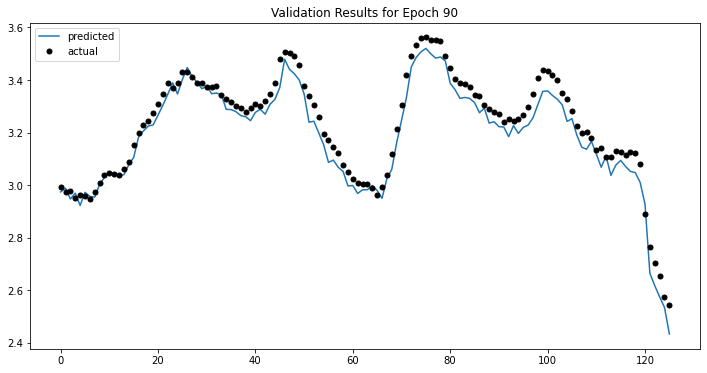

EarlyStopping counter: 43 out of 50
Iter:  91 train:  0.012649818313084763 val:  0.021238251593375595 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  92 train:  0.012600352264162685 val:  0.02101091966489728 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  93 train:  0.012595094297481828 val:  0.020333324685435035 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  94 train:  0.012554190820889969 val:  0.02002213845460748 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  95 train:  0.012551408031907959 val:  0.01959544108634873 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  96 train:  0.012586790873273076 val:  0.019994728868773685 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  97 train:  0.012530237339290949 val:  0.020001507141968956 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [54]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [55]:
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

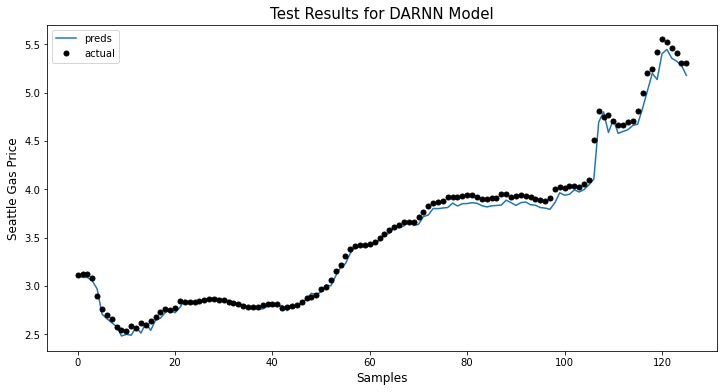

0.06265774369239807, 0.07225262932479382, 0.0914424005895853, 0.10103728622198105


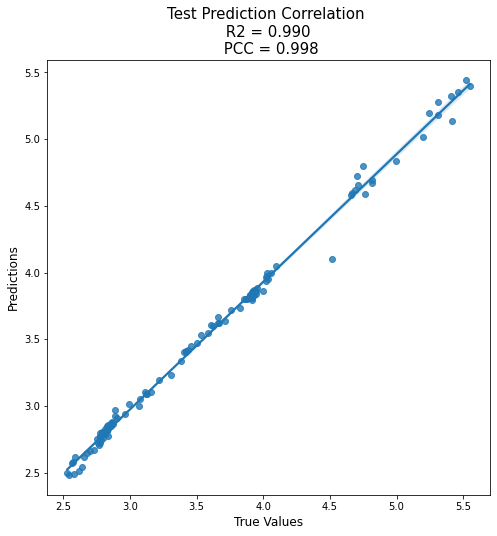

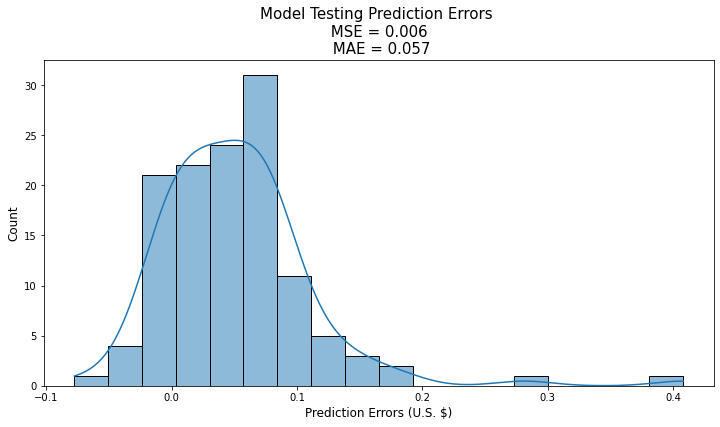

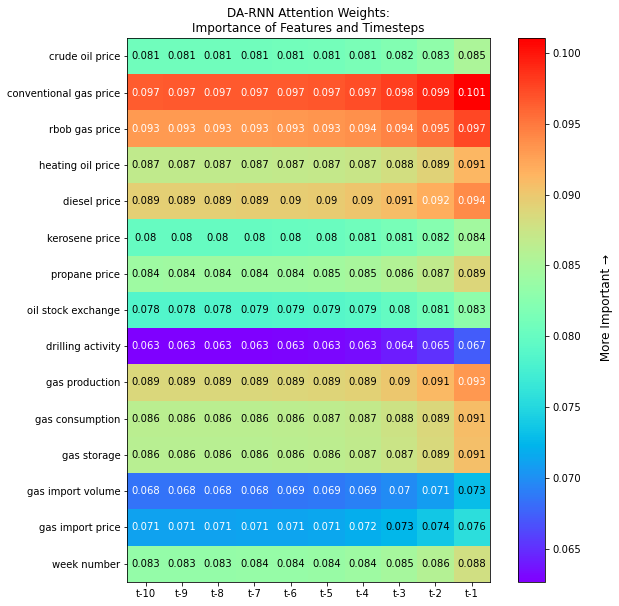

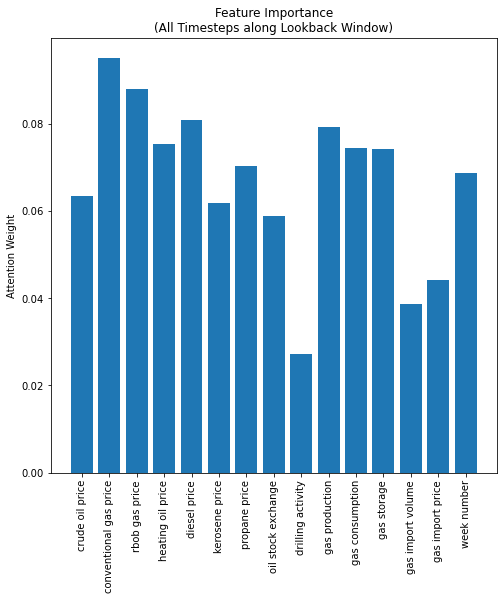

In [79]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true, darnn_alphas, darnn_betas = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

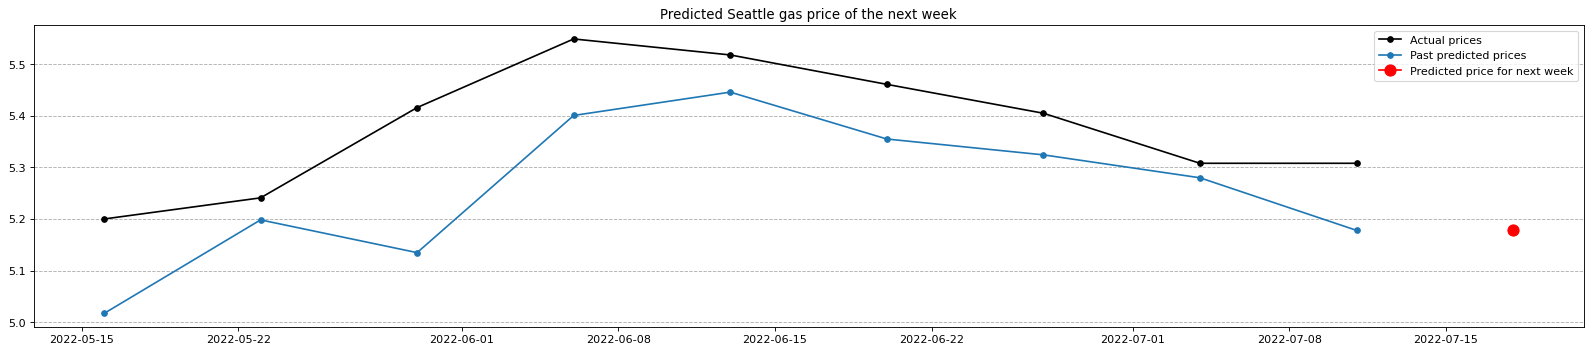

DARNN Predicted Seattle Gas Price of the next week: $5.18


In [57]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6d. Hierarchical Attention-Based Recurrent Highway Network (HARHN)

### Training

In [58]:
harhn = HARHN(n_conv_layers=3, 
              T=timesteps, 
              in_feats=n_timeseries, 
              target_feats=1, 
              n_units_enc=64, 
              n_units_dec=64, 
              device=device
             ).to(device)
model_name = 'harhn'
harhn_opt = torch.optim.Adam(harhn.parameters(), lr=0.01)
harhn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=harhn_opt, patience=15)

Validation loss decreased (inf --> 0.008918).  Saving model ...
Iter:  0 train:  0.22476296509134433 val:  0.09443711153904866 LR:  0.01
mse:  0.059410263 mae:  0.22467439


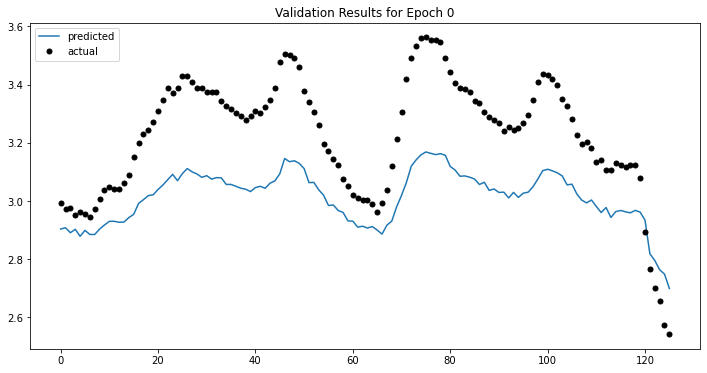

Validation loss decreased (0.008918 --> 0.000368).  Saving model ...
Iter:  1 train:  0.06292605592429776 val:  0.0191845881414436 LR:  0.01
Validation loss decreased (0.000368 --> 0.000170).  Saving model ...
Iter:  2 train:  0.022580852594075374 val:  0.013023322972917037 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  3 train:  0.019976546518111593 val:  0.018553975492175717 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  4 train:  0.019340796065305248 val:  0.024088888341509115 LR:  0.01
Validation loss decreased (0.000170 --> 0.000128).  Saving model ...
Iter:  5 train:  0.03007354259229742 val:  0.011324810433218162 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  6 train:  0.018443874008188116 val:  0.02617480830836029 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  7 train:  0.019197046906981898 val:  0.023105816450038258 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  8 train:  0.021500584617074256 val:  0.015925260697432386 LR:  0.01
Validation loss decreas

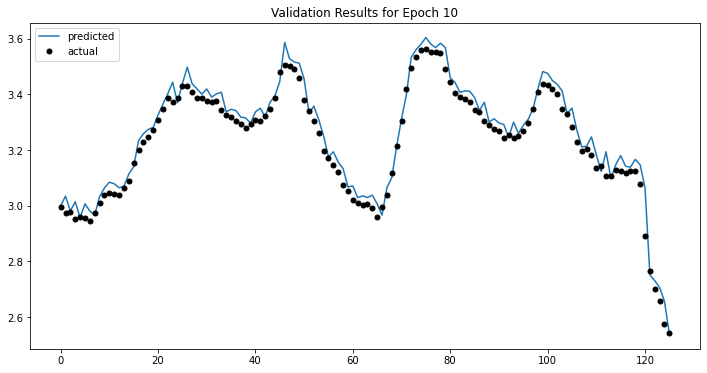

EarlyStopping counter: 2 out of 50
Iter:  11 train:  0.020226566904622763 val:  0.019674344658542103 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  12 train:  0.018428827030593183 val:  0.01296834529447618 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  13 train:  0.019112386352924775 val:  0.015543907320862615 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  14 train:  0.01804129682831165 val:  0.015761561603583045 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  15 train:  0.021414971838076717 val:  0.014721021287549624 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  16 train:  0.022000978853969573 val:  0.027477390545098943 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  17 train:  0.02210853155654174 val:  0.02062861246164146 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  18 train:  0.020499093512574378 val:  0.0118193123435099 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  19 train:  0.018505521244440735 val:  0.011399398097825484 LR:  0.01
EarlyS

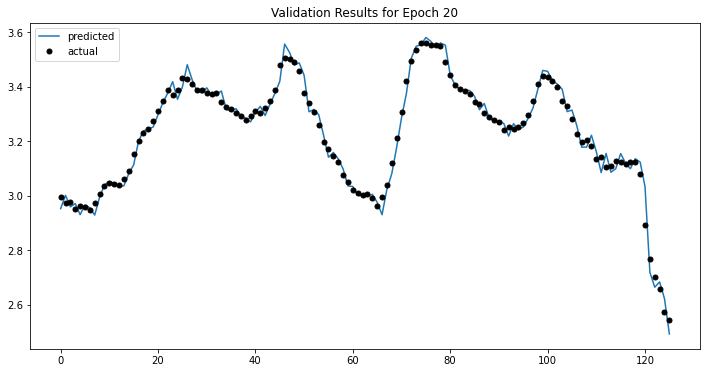

EarlyStopping counter: 12 out of 50
Iter:  21 train:  0.03427246753382891 val:  0.023992997448582885 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  22 train:  0.02857411974736173 val:  0.016891701332379643 LR:  0.01
Validation loss decreased (0.000121 --> 0.000117).  Saving model ...
Iter:  23 train:  0.018759549691510044 val:  0.010825740573568417 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  24 train:  0.017825463940724824 val:  0.01123678987620465 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  25 train:  0.019060788478580618 val:  0.011236211561055483 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  26 train:  0.02056017692775759 val:  0.012483373398020194 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  27 train:  0.021526160324551957 val:  0.031085899839394526 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  28 train:  0.022848740120151555 val:  0.019904299257545027 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  29 train:  0.022522643822678438 val:  

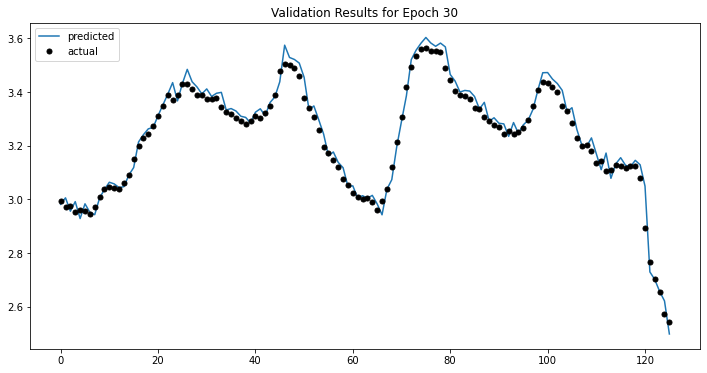

EarlyStopping counter: 8 out of 50
Iter:  31 train:  0.017304700292495548 val:  0.012392352681776235 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  32 train:  0.018804337005613316 val:  0.012065010390589614 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  33 train:  0.018294627438424457 val:  0.01991210806179257 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  34 train:  0.017948940112850715 val:  0.012638693522466521 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  35 train:  0.02096831150859143 val:  0.02645776064897147 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  36 train:  0.020104891654637438 val:  0.0136150279943946 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  37 train:  0.01764756273765134 val:  0.010990310044889411 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  38 train:  0.020158440169439698 val:  0.012751073725581935 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  39 train:  0.019569128788851132 val:  0.014098726590918553 LR:  0.001

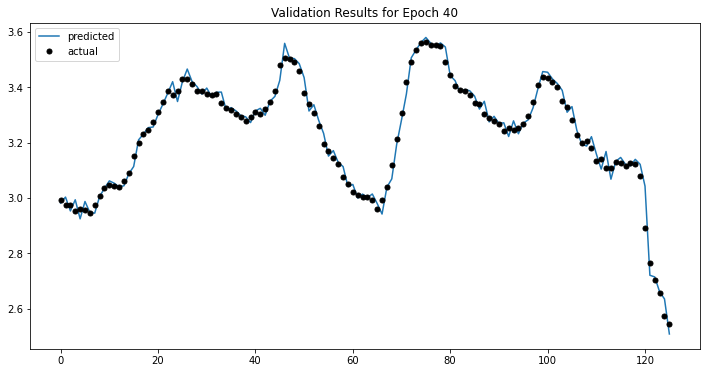

EarlyStopping counter: 18 out of 50
Iter:  41 train:  0.015981041308730577 val:  0.010839802717072286 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  42 train:  0.015739233628183136 val:  0.011559403313916682 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  43 train:  0.015442324945670348 val:  0.011736324429921122 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  44 train:  0.015838248366229313 val:  0.011982783504025705 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  45 train:  0.01570507394462517 val:  0.011011981049424953 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  46 train:  0.015559487320446392 val:  0.01090634684157213 LR:  0.001
Validation loss decreased (0.000117 --> 0.000117).  Saving model ...
Iter:  47 train:  0.015817695863938833 val:  0.010799694464394426 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  48 train:  0.015655873548389914 val:  0.011224245518416926 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  49 train:  0.01601819069

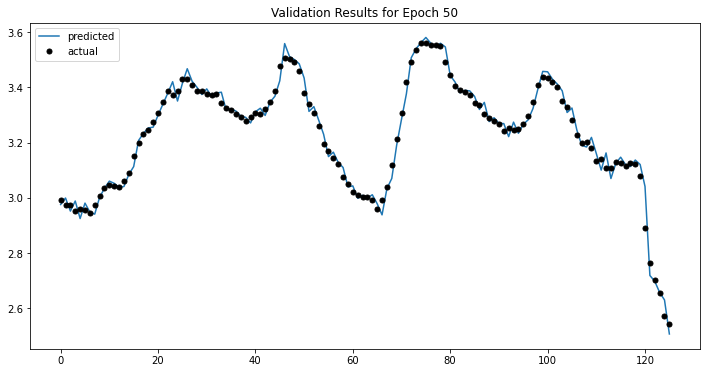

EarlyStopping counter: 4 out of 50
Iter:  51 train:  0.015563374182507724 val:  0.010959216756066509 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  52 train:  0.015527303378630139 val:  0.01104349492480401 LR:  0.001
EarlyStopping counter: 6 out of 50
Iter:  53 train:  0.01554296068359341 val:  0.010856411530929517 LR:  0.001
EarlyStopping counter: 7 out of 50
Iter:  54 train:  0.015580568218865517 val:  0.014257138230975143 LR:  0.001
EarlyStopping counter: 8 out of 50
Iter:  55 train:  0.015716704129699863 val:  0.010917479550855941 LR:  0.001
Validation loss decreased (0.000117 --> 0.000116).  Saving model ...
Iter:  56 train:  0.01555338295886414 val:  0.01076967645019383 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  57 train:  0.015617674885017493 val:  0.011234761664651123 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  58 train:  0.015569414735440315 val:  0.011026749748396193 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  59 train:  0.015834334823767487 

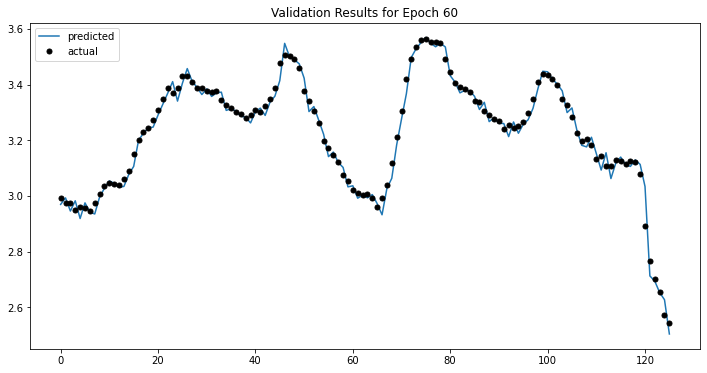

Validation loss decreased (0.000116 --> 0.000115).  Saving model ...
Iter:  61 train:  0.015556509904172887 val:  0.010729568200805744 LR:  0.001
EarlyStopping counter: 1 out of 50
Iter:  62 train:  0.0162085575758797 val:  0.011244930985039574 LR:  0.001
EarlyStopping counter: 2 out of 50
Iter:  63 train:  0.015944121731095915 val:  0.010828367389592398 LR:  0.001
EarlyStopping counter: 3 out of 50
Iter:  64 train:  0.01572096622955893 val:  0.011644758898136206 LR:  0.001
EarlyStopping counter: 4 out of 50
Iter:  65 train:  0.016110448060248795 val:  0.011878386069291577 LR:  0.001
EarlyStopping counter: 5 out of 50
Iter:  66 train:  0.015622690803644552 val:  0.011648070901865381 LR:  0.001
EarlyStopping counter: 6 out of 50
Iter:  67 train:  0.01553349745439319 val:  0.010762319370410731 LR:  0.001
EarlyStopping counter: 7 out of 50
Iter:  68 train:  0.01645719733311843 val:  0.010921873028593487 LR:  0.001
EarlyStopping counter: 8 out of 50
Iter:  69 train:  0.015852478615336053 v

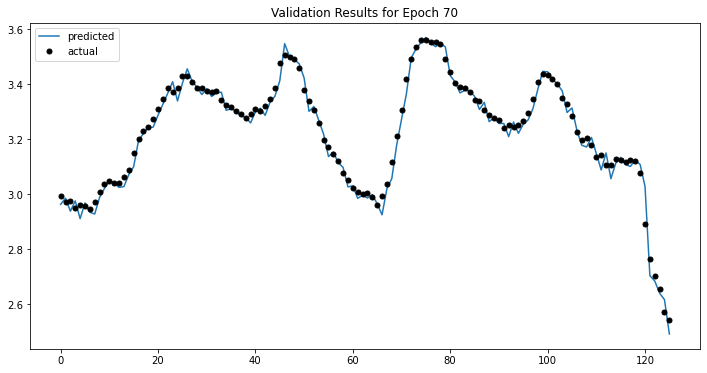

EarlyStopping counter: 10 out of 50
Iter:  71 train:  0.015620319559728675 val:  0.011024143048264724 LR:  0.001
EarlyStopping counter: 11 out of 50
Iter:  72 train:  0.016053536302097784 val:  0.011746884900418714 LR:  0.001
EarlyStopping counter: 12 out of 50
Iter:  73 train:  0.01706817753719039 val:  0.01276755080010045 LR:  0.001
EarlyStopping counter: 13 out of 50
Iter:  74 train:  0.01603357501275506 val:  0.012567304147987053 LR:  0.001
EarlyStopping counter: 14 out of 50
Iter:  75 train:  0.01566214198213857 val:  0.011029113922464105 LR:  0.001
EarlyStopping counter: 15 out of 50
Iter:  76 train:  0.01573641529165688 val:  0.01086242017143216 LR:  0.001
EarlyStopping counter: 16 out of 50
Iter:  77 train:  0.01548876854899522 val:  0.011251244786787318 LR:  0.0001
EarlyStopping counter: 17 out of 50
Iter:  78 train:  0.015254584950960446 val:  0.0107877422594428 LR:  0.0001
EarlyStopping counter: 18 out of 50
Iter:  79 train:  0.0152693088740267 val:  0.01080723611331932 LR: 

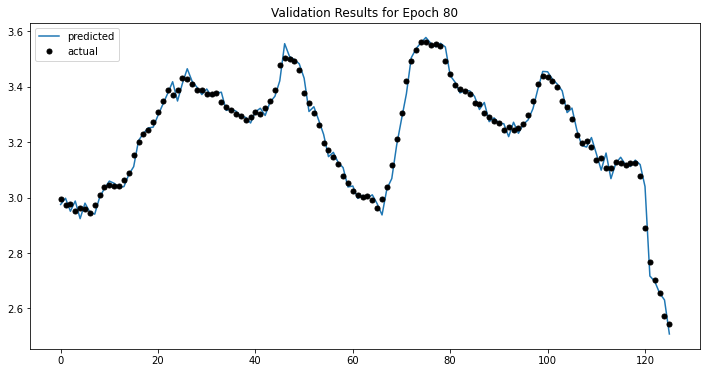

EarlyStopping counter: 20 out of 50
Iter:  81 train:  0.015262462192751331 val:  0.010813064106170401 LR:  0.0001
EarlyStopping counter: 21 out of 50
Iter:  82 train:  0.015264447043790073 val:  0.01102163999421712 LR:  0.0001
EarlyStopping counter: 22 out of 50
Iter:  83 train:  0.015282368374872844 val:  0.01084934477889277 LR:  0.0001
EarlyStopping counter: 23 out of 50
Iter:  84 train:  0.01527948680338323 val:  0.010790891723857164 LR:  0.0001
EarlyStopping counter: 24 out of 50
Iter:  85 train:  0.01535107540615433 val:  0.010800050845086085 LR:  0.0001
EarlyStopping counter: 25 out of 50
Iter:  86 train:  0.01526577642670778 val:  0.010817174721344419 LR:  0.0001
EarlyStopping counter: 26 out of 50
Iter:  87 train:  0.015288972799732839 val:  0.010821825930282282 LR:  0.0001
EarlyStopping counter: 27 out of 50
Iter:  88 train:  0.015260960063800687 val:  0.010997660681455305 LR:  0.0001
EarlyStopping counter: 28 out of 50
Iter:  89 train:  0.015273700091237201 val:  0.0108322853

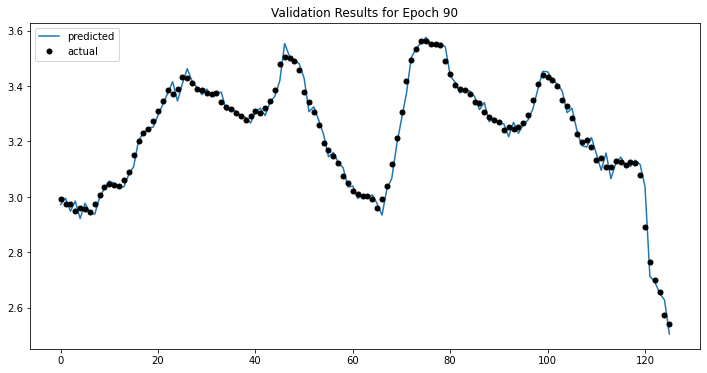

EarlyStopping counter: 30 out of 50
Iter:  91 train:  0.015263480960608469 val:  0.011513830441377914 LR:  0.0001
EarlyStopping counter: 31 out of 50
Iter:  92 train:  0.015345205011543553 val:  0.010843697706557728 LR:  0.0001
EarlyStopping counter: 32 out of 50
Iter:  93 train:  0.015244387624025815 val:  0.011340992392420986 LR:  1e-05
EarlyStopping counter: 33 out of 50
Iter:  94 train:  0.015333725169984982 val:  0.01099379479606445 LR:  1e-05
EarlyStopping counter: 34 out of 50
Iter:  95 train:  0.015233153157716084 val:  0.010892151611663374 LR:  1e-05
EarlyStopping counter: 35 out of 50
Iter:  96 train:  0.01522036953573449 val:  0.010844794594264712 LR:  1e-05
EarlyStopping counter: 36 out of 50
Iter:  97 train:  0.01520630105900463 val:  0.010868355823649605 LR:  1e-05
EarlyStopping counter: 37 out of 50
Iter:  98 train:  0.015213531112929994 val:  0.010880160135945326 LR:  1e-05
EarlyStopping counter: 38 out of 50
Iter:  99 train:  0.015209401404535304 val:  0.01086675016373

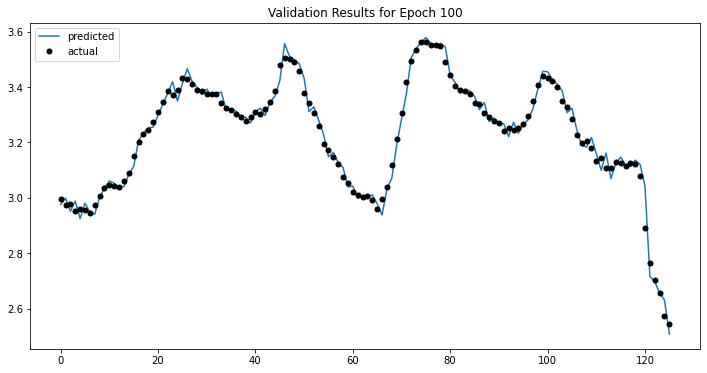

EarlyStopping counter: 40 out of 50
Iter:  101 train:  0.015210234999249693 val:  0.010859787150231651 LR:  1e-05
EarlyStopping counter: 41 out of 50
Iter:  102 train:  0.01521528206670623 val:  0.010851415738378757 LR:  1e-05
EarlyStopping counter: 42 out of 50
Iter:  103 train:  0.015213100021657969 val:  0.010857274776923085 LR:  1e-05
EarlyStopping counter: 43 out of 50
Iter:  104 train:  0.015210936750643217 val:  0.010857073858956432 LR:  1e-05
EarlyStopping counter: 44 out of 50
Iter:  105 train:  0.015215315838061442 val:  0.010899179355591815 LR:  1e-05
EarlyStopping counter: 45 out of 50
Iter:  106 train:  0.015211314774161166 val:  0.010852507653095946 LR:  1e-05
EarlyStopping counter: 46 out of 50
Iter:  107 train:  0.015221394718744391 val:  0.01083534238683421 LR:  1e-05
EarlyStopping counter: 47 out of 50
Iter:  108 train:  0.015210391598166884 val:  0.010906170188196727 LR:  1e-05
EarlyStopping counter: 48 out of 50
Iter:  109 train:  0.015211296933511129 val:  0.010868

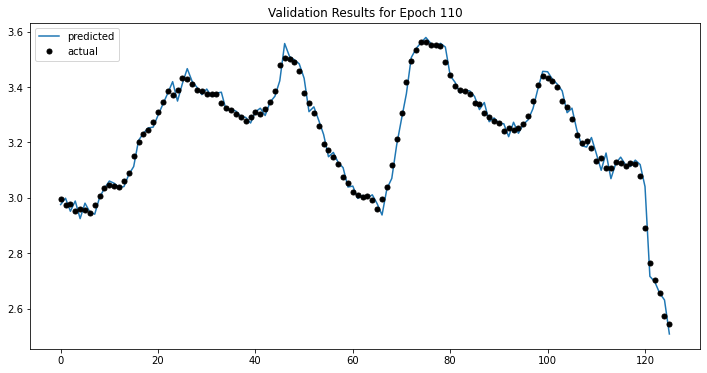

EarlyStopping counter: 50 out of 50
Early stopping


In [59]:
nn_train(model=harhn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=harhn_opt, 
         scheduler=harhn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [60]:
harhn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

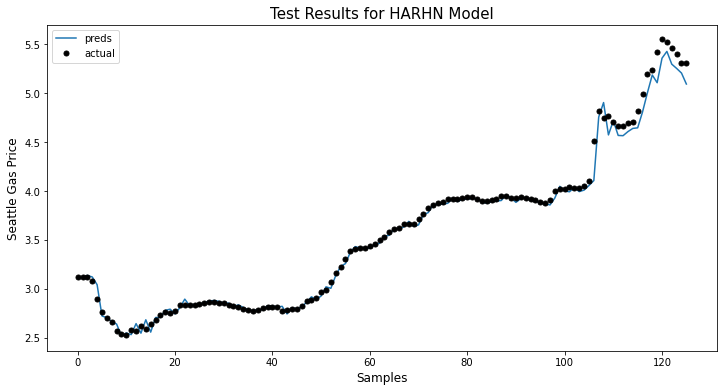

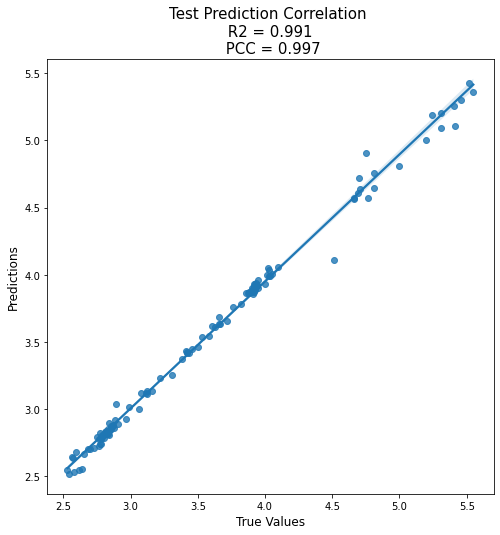

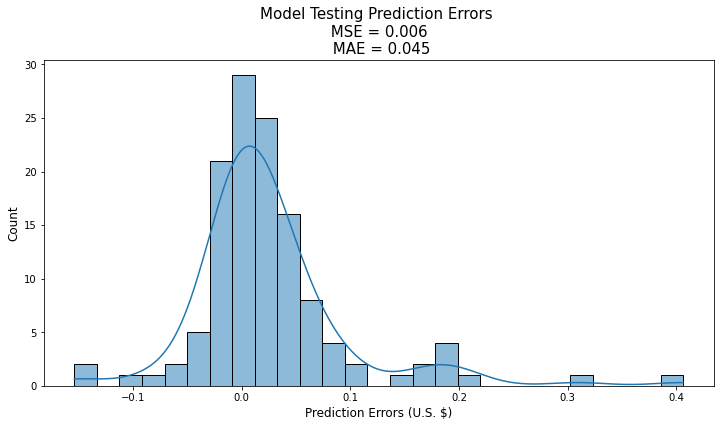

In [61]:
harhn_mse, harhn_mae, harhn_r2, harhn_pcc, harhn_preds, harhn_true, _, _ = nn_eval(model=harhn, 
                                                                             model_name='harhn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecast

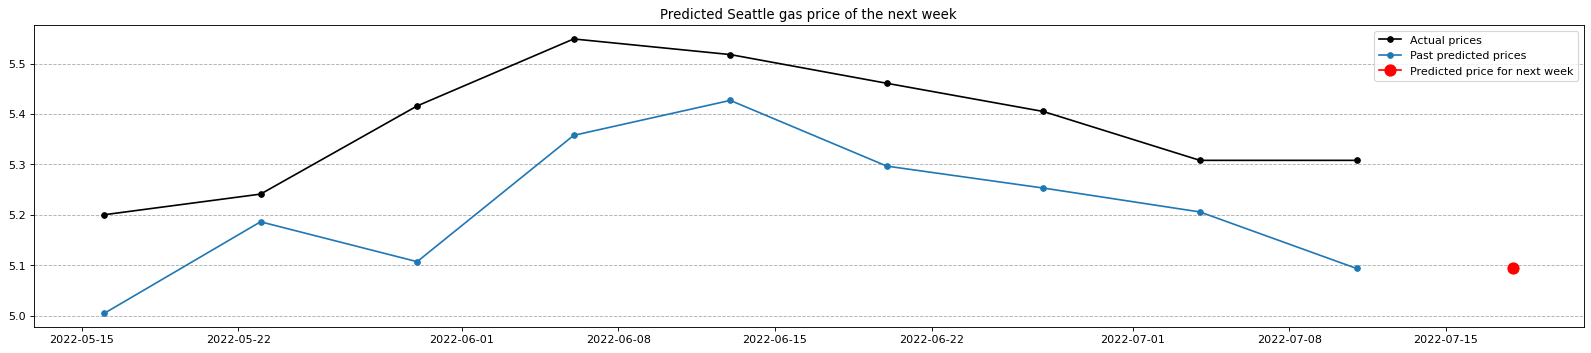

HARHN Predicted Seattle Gas Price of the next week: $5.09


In [62]:
nn_forecast(model = harhn,
            model_name = 'harhn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = harhn_true, 
            preds = harhn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

# 8. Model Comparison